In [1]:
'''
Date: 10 Apr 2020

Python version:      3.7
PyTorch version:     1.2.0

@author: Maksim Lavrov

CIFAR10 dataset

VGG16 baseline model
'''

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

import sys
print(sys.path)
sys.path.append('/home/mlavrov/meng_proj/Imperial_Flexible_CNNs/Fooling_around_foolbox')

from models.VGG16_with_flex_v8 import *

epsilons = [0, .05, .1, .15, .2, .25, .3]

# ======================================== prepare the dataset ==========================================================================================
mean_cifar10 = [0.485, 0.456, 0.406]   
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 1

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

testset = torchvision.datasets.CIFAR10(root='../../FlexibleCNNs/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = VGG16().to(device)

# Load the pretrained model
state = torch.load('../Fooling_around_foolbox/models/VGG16-flex-v8-block1-model_150_88.pth')
model.load_state_dict(state['model'])

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

['/home/mlavrov/meng_proj/Imperial_Flexible_CNNs/Filter_outputs', '/home/mlavrov/anaconda3/envs/meng/lib/python37.zip', '/home/mlavrov/anaconda3/envs/meng/lib/python3.7', '/home/mlavrov/anaconda3/envs/meng/lib/python3.7/lib-dynload', '', '/home/mlavrov/anaconda3/envs/meng/lib/python3.7/site-packages', '/home/mlavrov/anaconda3/envs/meng/lib/python3.7/site-packages/IPython/extensions', '/home/mlavrov/.ipython']
Files already downloaded and verified
CUDA Available:  True


VGG16(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): FlexiLayer(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.3, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

#evaluate model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print('Accuracy on the test dataset is: %f %%' % (
    100 * correct / total))

ReLU()
8 ship
torch.Size([64, 32, 32])


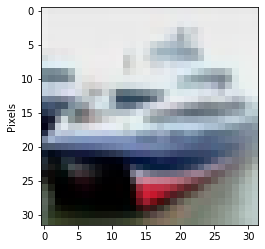

<Figure size 432x288 with 0 Axes>

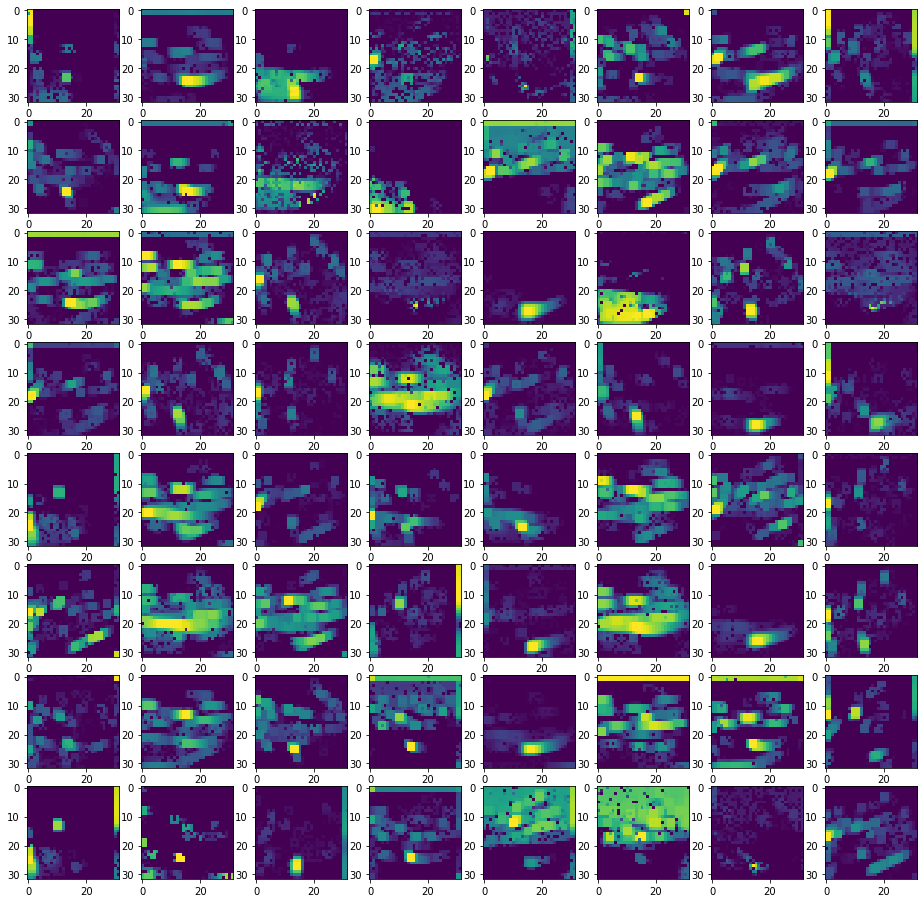

In [5]:
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

mean_cifar10 = [0.485, 0.456, 0.406]  # Mean and Std value hase been taken from a github implmentation online.
std_cifar10 = [0.229, 0.224, 0.225]
std= torch.FloatTensor(std_cifar10)
mean = torch.FloatTensor(mean_cifar10)
mean = mean[:,None,None]
std = std[:,None,None]
def imshow(img):
    img = img*std.cpu().detach().numpy() + mean.cpu().detach().numpy()     # unnormalize
    
    npimg = img
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

for idx, m in enumerate(model.block1.modules()):
    #print(m)
    if idx == 6:
        
        print(m)
        m.register_forward_hook(get_activation('conv2'))
        data, label = testset[1]
        data.unsqueeze_(0)
        output = model(data.cuda())
        plt.figure()
        plt.ylabel('Pixels')
        imshow(data[0].cpu().detach().numpy())
        print(label, 'ship')


        act = activation['conv2'].squeeze()
        print(act.size())
        #fig, axarr = plt.subplots(act.size(0))
        fig = plt.figure()
        fig = plt.figure(figsize=(16,16))
        for idx in range(act.size(0)):
            im = plt.subplot(8,8, idx + 1)
            plt.imshow(act.cpu()[idx,:,:]) # cmap="gray"
            #axarr[idx].imshow(act[idx], cmap="gray")

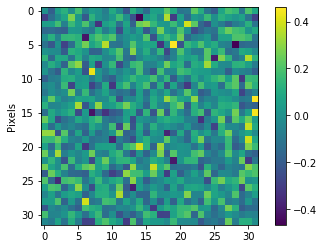

In [3]:
#after training
for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        imgplot = plt.imshow(m.threshold1.cpu().detach().numpy()[0,1,:])
        plt.colorbar()
        plt.ylabel('Pixels')

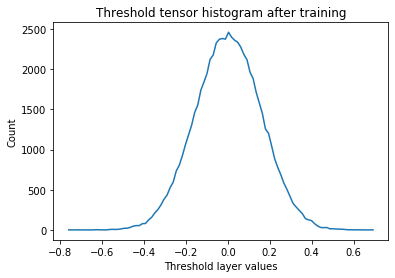

In [4]:
#Plot the new learned distribution

for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        
        thresh_hist = torch.histc(m.threshold1)
        start = np.min(m.threshold1.cpu().detach().numpy())
        end = np.max(m.threshold1.cpu().detach().numpy())
        xhist = torch.linspace(start,end,100) # histogram x-axis
        plt.plot(xhist, thresh_hist.cpu().detach().numpy())
        plt.title('Threshold tensor histogram after training')
        plt.ylabel('Count')
        plt.xlabel('Threshold layer values')